# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [6]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [7]:
!pip install pygame
!pip install 'stable-baselines3[extra]'
# !pip install stable_baselines3
!pip install pyglet==1.5.27

In [8]:
import gym
from gym import spaces
from gym.spaces import MultiDiscrete, Discrete, Box
import pygame
import numpy as np

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
#     metadata = {'render.modes': ['human']}
#     Everything is stored as batch. one setp_size=one whole pass on the train dataset

    def __init__(self, dataset_name):
        super(CustomEnv, self).__init__()
        self.name=dataset_name
        self.current_step = 0
        self.binarize_step = 0
        X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)
        self.X=X_train
        self.y=y_train
        self.X_test = X_test
        self.y_test = y_test
        # X is (n,d)
        # y is (n,k)
        # probas is (n,k)
        self.n = X_train.shape[0]
        self.d = X_train.shape[1]
        self.k = y_train.shape[1]
        self.reward_range = (0, self.k)     
#         self.action_space = spaces.Box(
#           low=np.zeros(shape=self.k), high=np.ones(shape=self.k), dtype=np.int32)
        self.action_space = MultiDiscrete(2*np.ones(shape=self.k))#Tuple((Discrete(2), Box(0, 1, (self.k,))))
        self.observation_space = spaces.Box(
          low=np.array([-1.]*self.d), high=np.array([1.]*self.d), dtype=np.float16)

    def get_X_train(self):
        return self.X
    
    def get_X_test(self):
        return self.X_test
    
    def get_y_test(self):
        return self.y_test
    
    def step(self, action):
        obs = self._next_observation()
        if self.binarize_step == 0:
            reward = 0
            done = False
        else:
            truth = self.y[self.current_step]
            reward = (1 - np.logical_xor(action, truth)).sum()#.reshape((n,1))
            done = True
        self.current_step += 1 
        if self.current_step >= (self.n):
            self.current_step = 0
        self.binarize_step=self.current_step %2
        return (np.array(obs), reward, done, {})
    
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        return self.X[self.current_step]
    def _get_obs(self):
        obs = self.X[self.current_step]
        return obs
    def _get_info(self):
        return ""
    def _next_observation(self):
        obs = self.X[self.current_step]
        return obs

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


Eval on test dataset using the expected hamming loss:\
def expected_hamming_loss(self, X, y):\
    y_invert = 1 - y\
    invert_probas = self.predict_proba(X, y_invert)\
    return invert_probas.sum() / (self.k * y.shape[0])

In [26]:
from stable_baselines3.common.callbacks import BaseCallback
import pickle

class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.X_test=env.get_X_test()
        self.y_test=env.get_y_test()
        self.EHL_history=[]
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]


    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True
    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        res=[np.abs(self.model.predict(self.X_test)[0]-self.y_test).mean() for _ in range(10)]
        self.EHL_history+=[{'step': self.n_calls, 'EHLm': np.mean(res), 'EHLv': np.var(res)}]
        print('rollout:', self.n_calls, res)

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        with open(dataset_name+'.pickle', 'wb') as f:
            pickle.dump(self.EHL_history, f)

In [27]:
from stable_baselines3 import PPO

In [28]:
datasets=['tmc2007', 'scene', 'yeast']

In [29]:
# dataset_name='scene'
# dataset_name='yeast'
dataset_name='tmc2007'

# env = DummyVecEnv([lambda: CustomEnv(dataset_name)])
env = CustomEnv(dataset_name)
n_train = env.get_X_train().shape[0]
max_nb_rollout = 2**7

reducing dimension for TMC dataset
X_train: (21447, 1000) y_train: (21447, 22)


/opt/anaconda3/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


In [30]:
env.get_X_test().shape

(7149, 1000)

In [ ]:
callback = CustomCallback()
model = PPO("MlpPolicy", env, verbose=1, n_steps=n_train)
model.learn(total_timesteps=n_train*max_nb_rollout, callback = callback)
# model.save("ppo_cartpole")

In [ ]:
callback.EHL_history

Load and compare with other model

In [36]:
dataset_name='scene'
# dataset_name='yeast'
dataset_name='tmc2007'

In [37]:

with open(dataset_name+'.pickle', 'rb') as f:
    res = pickle.load(f)

In [38]:
replay_targets = 2**np.arange(6)

# res=callback.EHL_history
n_step=res[0]['step']
X=[i['step']/n_step for i in res]
Y=[i['EHLm'] for i in res]
# plt.plot(X,Y)
rollout_PPO=np.power(2,range(8)).astype(int)
PPO_loss=[Y[i-1] for i in rollout_PPO]

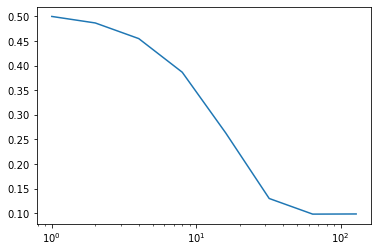

In [39]:
plt.plot(rollout_PPO,PPO_loss)
plt.xscale('log')


### Baselines & Skylines

In [40]:
X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)

reducing dimension for TMC dataset
X_train: (21447, 1000) y_train: (21447, 22)


In [41]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [ ]:
sampling_probas.min(axis=0)

In [ ]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

# The Experiment

In [ ]:
def expected_hamming_loss(self, X, y):
    y_invert = 1 - y
    invert_probas = self.predict_proba(X, y_invert)
    return invert_probas.sum() / (self.k * y.shape[0]) 

In [ ]:
from sklearn.metrics import hamming_loss

In [ ]:
def expected_hamming_loss(model, X, y):
        y_invert = 1 - y
        invert_probas = model.predict_proba(X, y_invert)
        k = y.shape[1]
        return invert_probas.sum() / (k * y.shape[0]) 

In [ ]:
crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        crm_model.fit(
            crm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)    
        crm_rewards[i,j] = (1 - np.logical_xor(crm_model.predict(X_test), y_test)).sum()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

In [ ]:
ucrm_losses = np.ones((10, len(replay_targets,)))
ucrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    ucrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    ucrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        ucrm_dataset.update_from_supervised_dataset(X_train, y_train, .5*np.ones_like(sampling_probas), n_samples=needed_replays)
        ucrm_model.fit(
            ucrm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        ucrm_losses[i,j] = ucrm_model.expected_hamming_loss(X_test, y_test)    
        ucrm_rewards[i,j] = (1 - np.logical_xor(ucrm_model.predict(X_test), y_test)).sum()
        
ucrm_losses = ucrm_losses.mean(axis=0)
ucrm_rewards = ucrm_rewards.mean(axis=0)

In [ ]:
scrm_losses = np.ones((10, len(replay_targets,)))
scrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        scrm_sampling_probas = scrm_model.predict_proba(X_train, y_train)
        scrm_dataset.update_from_supervised_dataset(X_train, y_train, scrm_sampling_probas, n_samples=needed_replays)
        scrm_model.fit(
            scrm_dataset, 
            lambda_ = -1 / np.sqrt(replay_target),
            verbose = 0
        )
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)    
        scrm_rewards[i,j] = (1 - np.logical_xor(scrm_model.predict(X_test), y_test)).sum()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)

In [ ]:
replay_targets

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Loss Evolution over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, .473*np.ones_like(replay_targets), '--', label='Baseline')
# ax.plot(replay_targets, Y, '--', label='Baseline')
ax.plot(replay_targets, ucrm_losses, 'o-', label='POEM Unif.')
ax.plot(rollout_PPO,PPO_loss, 'o-', label='PPO')
ax.plot(replay_targets, crm_losses, 'o-', label='POEM')

ax.plot(replay_targets, scrm_losses, 'o-', label='S-CRM')
#ax.plot(replay_targets, .295*np.ones_like(replay_targets), '--', label='Skyline (LR)')
ax.plot(replay_targets, .220*np.ones_like(replay_targets), '--', label='Skyline (NN)')
ax.set_ylabel('Hamming Loss')
ax.legend(loc=(1.2, .1))
plt.savefig(dataset_name+'_EHL.jpg')

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(500, 100, 40, 10,)), n_jobs=4).fit(X_train, y_train)

In [ ]:
baseline_rewards = (1 - np.logical_xor(pi0.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)
skyline_rewards = (1 - np.logical_xor(mlp.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Cumulated Regret over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(baseline_rewards), '--', label='Baseline')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(ucrm_rewards), 'o-', label='POEM Unif.')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(crm_rewards), 'o-', label='POEM')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
# ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(skyline_rewards), '--', label='Skyline')
ax.set_ylabel('Cumulated Regret')
ax.legend(loc=(1.2, .1))